# Разработка модели оценивания стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import time

In [2]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**В данных есть пропуски и не все значения в столбце соответствуют своему типу.**

Приведём столбцы с датой к формату datetime64

In [4]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

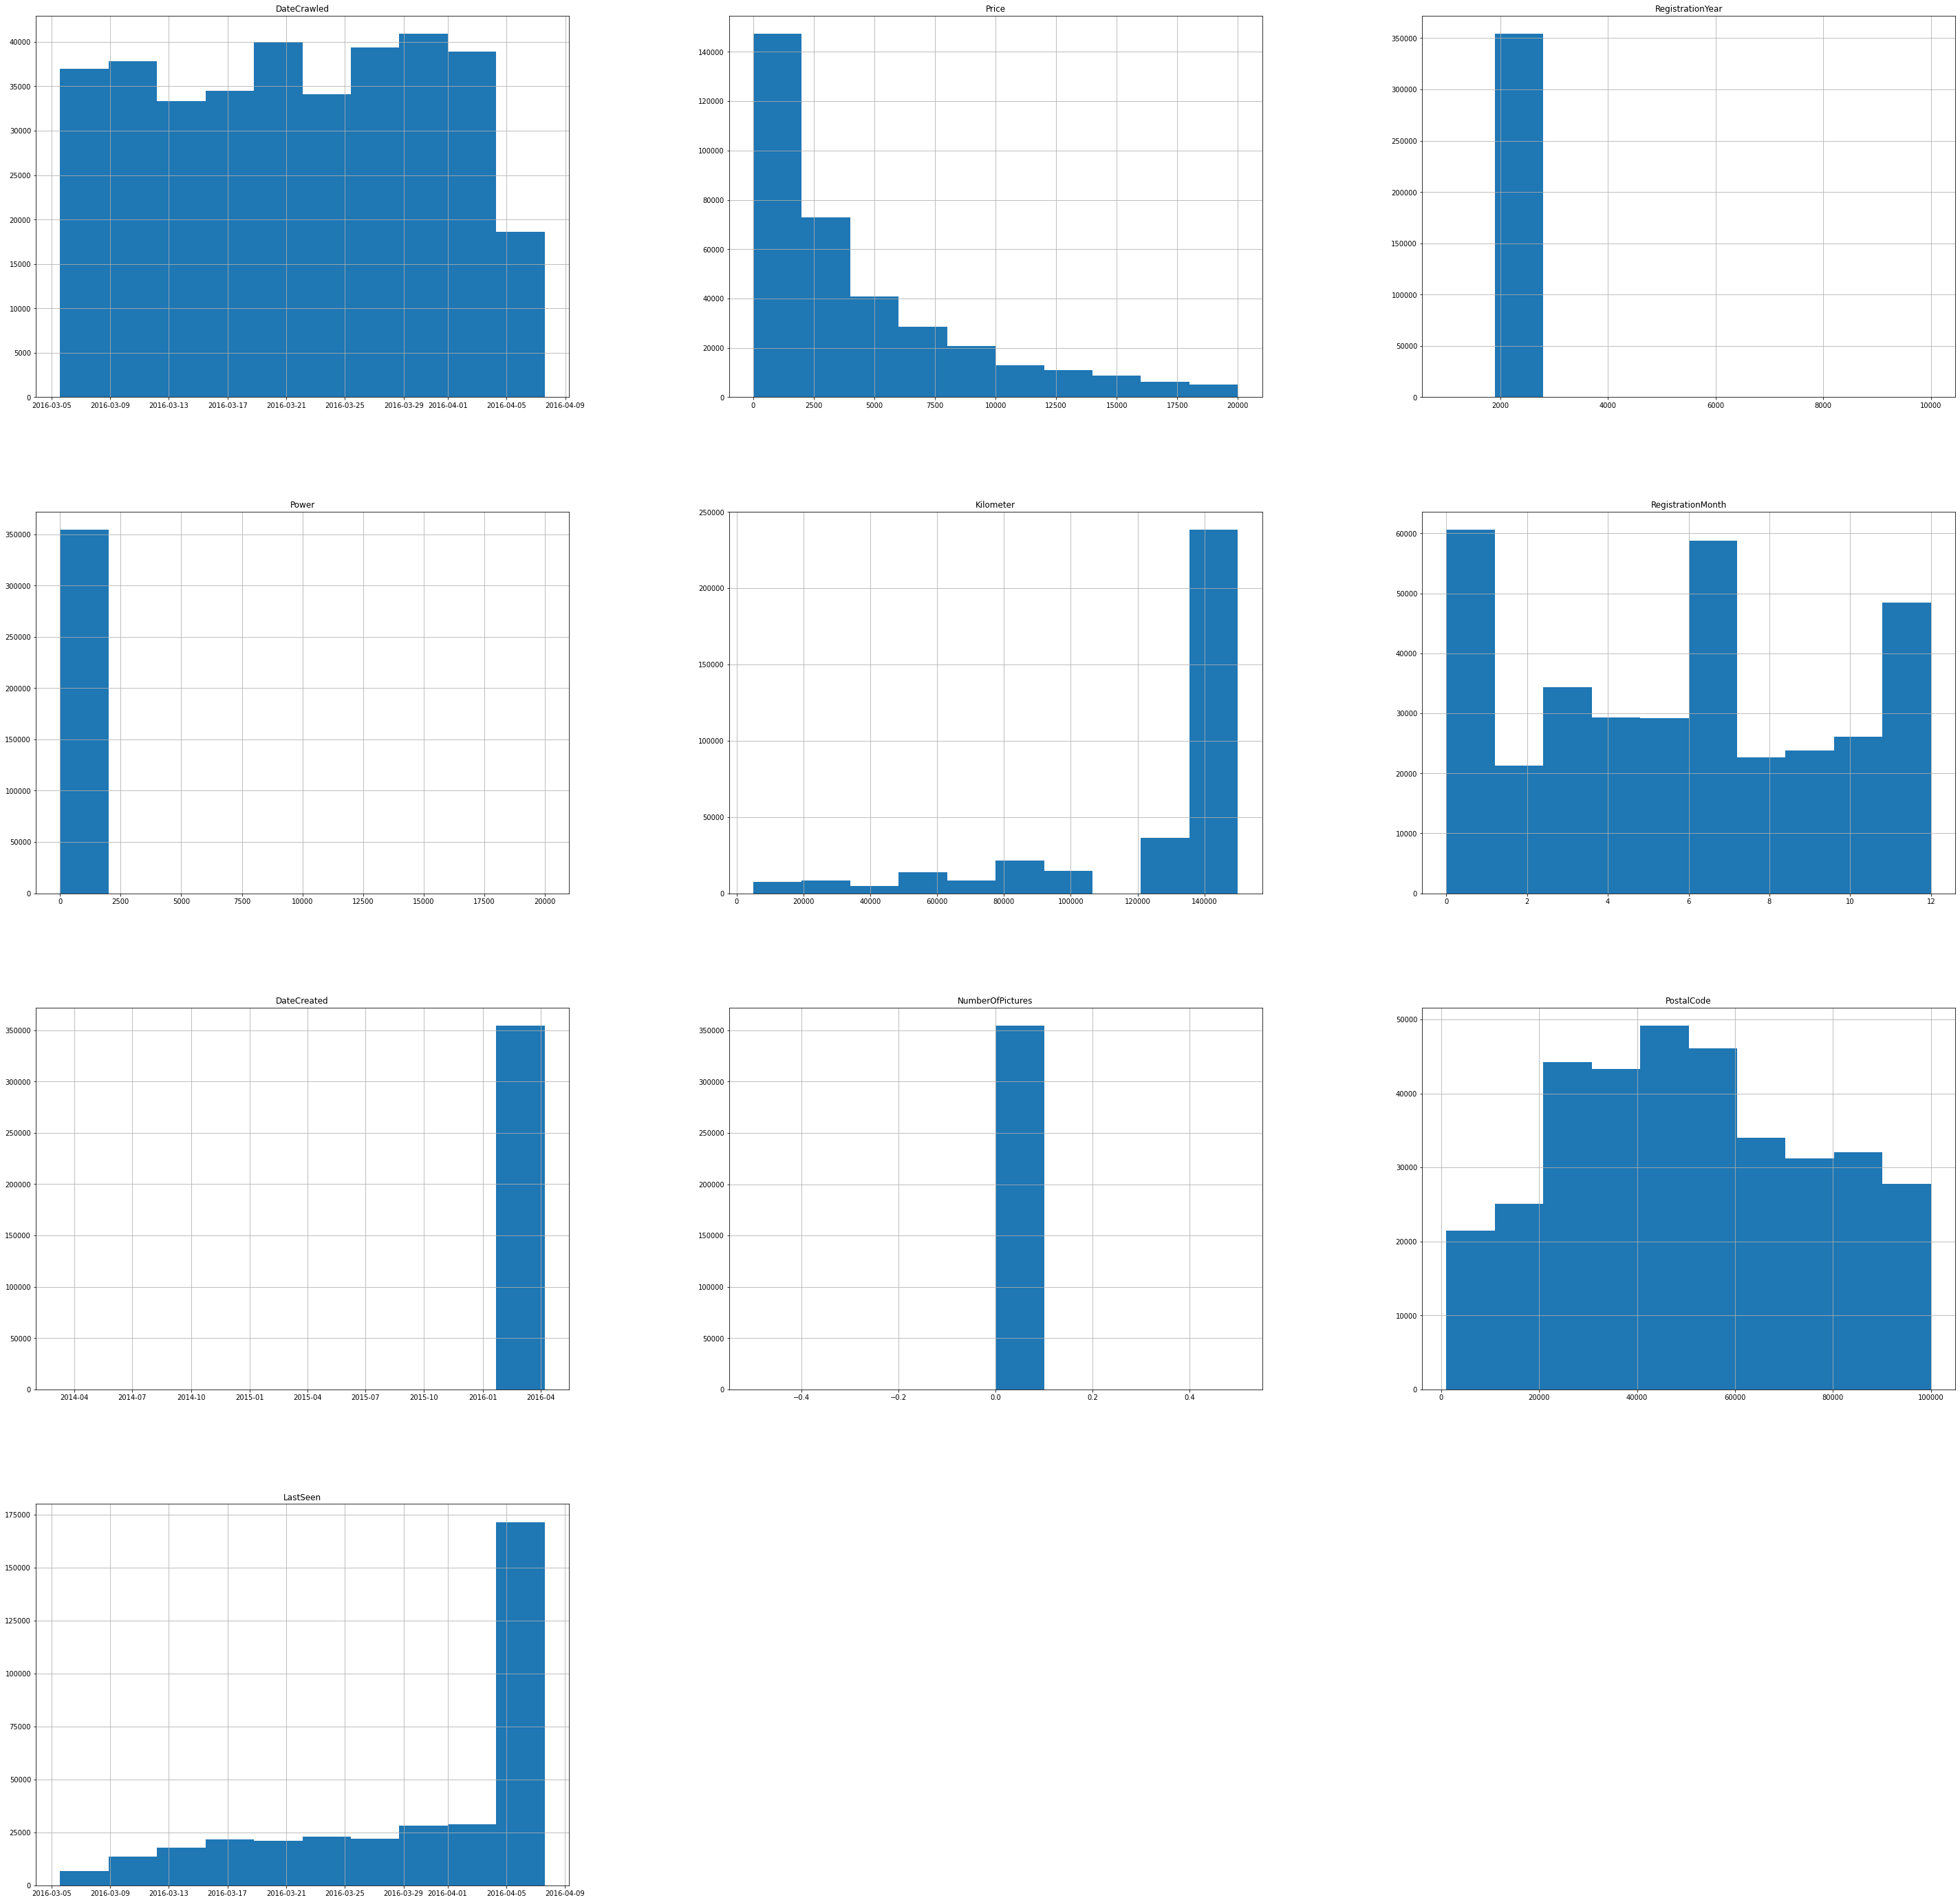

In [5]:
data.hist(figsize=(50, 50));

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Подозрительным кажется столбец NumberOfPictures, все его значения = 0**

**Разберем далее каждый столбец в отдельност**

In [7]:
# колличество пропусков в %
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


В 5 столбцах из 16 есть пропуски

Больштнство пропусков имеет стлбец: Repaired — была машина в ремонте или нет. 


<div class="alert alert-info">
<font size="4"></font>Если пропускков меньше 10% их лучше сразу удалить

In [8]:
#data = data.dropna(subset = ['VehicleType'])
#data = data.dropna(subset = ['Gearbox'])
data = data.dropna(subset = ['Model'])
#data = data.dropna(subset = ['FuelType'])

<div class="alert alert-info">
<font size="4"></font>
#значения где пропуски привышают 10% заменим заглушкой 

In [9]:
data['VehicleType']=data['VehicleType'].fillna('unknown')

In [10]:
data['Gearbox']=data['Gearbox'].fillna('unknown')

In [11]:
#data['Model']=data['Model'].fillna('unknown')

In [12]:
data['FuelType']=data['FuelType'].fillna('unknown')

In [13]:
# КОД РЕВЬЮЕРА
data.shape[0] / 354369

0.9443941202531824

<div class="alert alert-info">
<font size="4"></font> удалила пропуски только в одном столбце, что примерно - 6% )

In [14]:
data['Repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

**В столбце Repaired почти 20% не имеют значчений, это довольно много, поэтому поставим заглушку "unknown"**

In [15]:
data['Repaired']=data['Repaired'].fillna('unknown')

In [16]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

**Пропуски обработаны**

In [17]:
data.loc[(data['Price'] < 500), 'Price'].count()

31030

**Вряд ли есть хорошая машина в нормальном состоянии дешевле 500 евро(45000рубл**

In [18]:
data = data.query('Price> 500') #отсеиваем значения по цене

**Рассмотрим год регистрации машин** 


Машины выпущенные позже 90-ых годов являются уже очень старыми, и являются либо не пригодными для использования либо коллекционными/антиквариатом 

In [21]:
data.RegistrationYear.unique()

array([2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 2007, 2009, 2002,
       2018, 2017, 1981, 2003, 2016, 1991, 1984, 2006, 1999, 2012, 2010,
       2000, 1992, 1993, 1997, 2013, 1994, 1996, 1990, 1989, 2015, 1985,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965,
       1970, 1945, 1974, 1955, 1978, 1979, 1972, 1968, 1977, 1966, 1975,
       1910, 1963, 1967, 9999, 1960, 1500, 1964, 2066, 1949, 2019, 1937,
       1951, 1959, 1953, 1954, 1958, 1956, 1962, 9000, 2900, 5911, 1400,
       5000, 1961, 4000, 1952, 8500, 1932, 1950, 1000, 3700, 1942, 1933,
       1936, 1957, 1923, 2290, 1930, 1001, 7000, 1929, 1943, 1938, 1934,
       1935, 1928, 1941, 5555, 1800, 6000, 1931, 4500, 7800, 1947, 1927,
       7100, 1600])

In [22]:
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1990)]
data.RegistrationYear.unique()

array([2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 2007, 2009, 2002,
       2003, 2016, 1991, 2006, 1999, 2012, 2010, 2000, 1992, 1993, 1997,
       2013, 1994, 1996, 1990, 2015])

**В среднем мощность машины от 100 до 500**, 
но возьмем более широкий диапозон в качестве всевозможных исключений

In [23]:
#Колличество объявлений с некорректной мощностью:
len(data.loc[(data['Power'] > 1000) | (data['Power'] < 30)])

20725

In [24]:
data=data.query('Power > 30 & Power < 1000')

In [25]:
print(data.RegistrationMonth.unique())
data.RegistrationMonth.value_counts()

[ 8  6  7 10  0 12 11  2  3  1  4  9  5]


3     27019
6     24467
4     22747
5     22690
7     21061
10    20842
11    19107
12    19069
9     18968
1     17823
8     17719
2     16632
0     11497
Name: RegistrationMonth, dtype: int64

**Так как значений равных нулю не много можем просто избавиться от них**

In [26]:
#data=data.query('RegistrationMonth !=0')
#data.RegistrationMonth.unique()

In [27]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'honda', 'fiat', 'opel',
       'mini', 'smart', 'hyundai', 'audi', 'subaru', 'volvo',
       'mitsubishi', 'alfa_romeo', 'kia', 'seat', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler',
       'jaguar', 'daewoo', 'rover', 'porsche', 'saab', 'land_rover',
       'lada', 'trabant'], dtype=object)

**Все названия корректны, пропусков нет, неявных дубликатов нет**

In [28]:
data.DateCreated.describe()

/tmp/ipykernel_402/892293459.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.DateCreated.describe()


count                  259641
unique                    105
top       2016-04-03 00:00:00
freq                    10323
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

**Аномалий не выявлено**

In [29]:
data.PostalCode.unique()

array([90480, 91074, 60437, ..., 24363, 95691, 86751])

**Можем предположить, что индекс не влияет на цену машины**

In [30]:
data.LastSeen.describe()

/tmp/ipykernel_402/4000383376.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.LastSeen.describe()


count                  259641
unique                 138222
top       2016-04-07 13:17:48
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

In [31]:
data.corr().style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.621305,0.490411,-0.402732,0.045760,nan,0.059636
RegistrationYear,0.621305,1.000000,0.096093,-0.438174,0.018828,nan,0.028611
Power,0.490411,0.096093,1.000000,0.119656,0.024316,nan,0.047306
Kilometer,-0.402732,-0.438174,0.119656,1.000000,-0.012962,nan,-0.011782
RegistrationMonth,0.045760,0.018828,0.024316,-0.012962,1.000000,nan,-0.000050
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.059636,0.028611,0.047306,-0.011782,-0.000050,nan,1.000000


**Цена подержанного автомобиля складывается из нескольких параметров, в том числе мощности и года регистрации автомобиля, которые имеют сильную положительную корреляцию. С другой стороны, пробег оказывает сильное отрицательное влияние на стоимость автомобиля, поскольку больший пробег дает потребителям основание переживать за состояние и долговечность автомобиля. Однако, следует учитывать, что марка и модель, оснащение и состояние кузова и двигателя также вносят свой вклад в ценообразование подержанных автомобилей.**

In [32]:
data_cor = data.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen','RegistrationMonth'], axis=1)

In [33]:
data_cor.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2016-04-01


In [34]:
data_cor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259641 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Price             259641 non-null  int64         
 1   VehicleType       259641 non-null  object        
 2   RegistrationYear  259641 non-null  int64         
 3   Gearbox           259641 non-null  object        
 4   Power             259641 non-null  int64         
 5   Model             259641 non-null  object        
 6   Kilometer         259641 non-null  int64         
 7   FuelType          259641 non-null  object        
 8   Brand             259641 non-null  object        
 9   Repaired          259641 non-null  object        
 10  DateCreated       259641 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 23.8+ MB


In [35]:
#исследование на дубликаты 
data_cor[data_cor.duplicated(keep=False)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no,2016-03-21
47,2100,wagon,1998,auto,193,5er,150000,petrol,bmw,no,2016-04-03
64,14999,convertible,2007,manual,218,3er,50000,petrol,bmw,no,2016-03-07
66,9700,coupe,2008,manual,160,scirocco,150000,petrol,volkswagen,no,2016-03-15
84,1600,wagon,1997,auto,122,forester,150000,petrol,subaru,no,2016-03-12
...,...,...,...,...,...,...,...,...,...,...,...
354311,3000,sedan,2006,manual,105,golf,150000,gasoline,volkswagen,no,2016-03-08
354317,5990,small,2009,manual,86,ibiza,90000,petrol,seat,no,2016-03-19
354344,1600,wagon,1998,manual,125,a4,150000,petrol,audi,no,2016-04-01
354352,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no,2016-03-05


In [36]:
data_cor = data_cor.drop_duplicates() #удаляем дубликаты

In [37]:
# КОД РЕВЬЮЕРА
data_cor.duplicated().sum()

0

In [38]:
data_cor=data_cor.reset_index(drop=True) #сбрасываем индексы полсле преобразований

In [39]:
features=data_cor.drop(['Price'],axis=1)
target=data_cor['Price']

**Разделим данные на основную выборку и целевые признаки**

In [40]:
state = np.random.RandomState(12345) #фиксируем значение для упрощения кода в дальнейшем

**Разбиваем на тестовую и тренеровочную выборки**

**Кодирование категориальных признаков**

**Преобразую категориальные признаки техникой Ordinal Encoding.**

In [41]:
# Разделение данных на тренировочный, валидационный и тестовый наборы
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.2, random_state=state
)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_val, target_train_val, test_size=0.25, random_state=state
)

In [48]:
column = ['VehicleType', 'Gearbox','Model','FuelType', 'Brand', 'Repaired', 'DateCreated']
encoder = OrdinalEncoder(handle_unknown='ignore', unknown_value=None)
encoder.fit(features_train[column])
features_train[column] = encoder.transform(features_train[column])
features_valid[column] = encoder.transform(features_valid[column])
features_test[column] = encoder.transform(features_test[column])

#features_train

/tmp/ipykernel_402/4212154399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[column] = encoder.transform(features_train[column])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_402/4212154399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [49]:
numeric=['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','Repaired','DateCreated']
scaler=StandardScaler()
scaler.fit(features_train[numeric])


features_train[numeric]=scaler.transform(features_train[numeric]) #масштабируем признаки
features_test[numeric]=scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


print(features_train.shape)
print(features_test.shape)

features_train.head()

/tmp/ipykernel_402/1289667695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric]=scaler.transform(features_train[numeric]) #масштабируем признаки
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


(149296, 10)
(49766, 10)


/tmp/ipykernel_402/1289667695.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric]=scaler.transform(features_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_402/1289667695.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated
169329,-0.220033,-0.515161,0.449960,0.223705,0.847743,-0.074770,0.681435,-0.395775,-0.469577,1.314042
15658,0.597172,0.802132,0.449960,0.353878,0.847743,0.606860,-1.407429,-0.776535,-0.469577,1.530519
48628,1.414376,0.802132,0.449960,0.484052,0.464761,0.606860,-1.407429,0.974962,2.860555,-1.283686
212718,0.188570,-2.585191,2.775641,1.246497,0.847743,-3.346597,0.681435,0.365746,1.195489,-1.283686
77027,-0.220033,1.366685,0.449960,1.116323,-1.350854,0.606860,-1.407429,-1.385752,-0.469577,1.422280


**Вывод** исходные данные имели пропуски, некорректные значения и дубликаты. После устранения недостатков мы преобразовали категориальныые признаки, разбили на выборки и отмасштабировали их.

## Обучение моделей

**RandomForestRegressor**

In [51]:
%%time
forest_model = RandomForestRegressor(
    random_state=state, criterion='mse',warm_start=False, n_estimators=20, max_depth = 15)
forest_model.fit(features_train, target_train)

CPU times: user 5.85 s, sys: 29.4 ms, total: 5.88 s
Wall time: 5.88 s


RandomForestRegressor(max_depth=15, n_estimators=20,
                      random_state=RandomState(MT19937) at 0x7F9013B1C940)

In [52]:
%%time
# Получение предсказаний модели на валидационном наборе данных
pred_forest_model = forest_model.predict(features_valid)

CPU times: user 179 ms, sys: 3.97 ms, total: 183 ms
Wall time: 188 ms


In [53]:
# Оценка качества модели на валидационном наборе данных
mse_forest_model = mean_squared_error(target_valid, pred_forest_model)
print('RMSE для случайного леса:', round((mse_forest_model) ** 0.5, 2))

RMSE для случайного леса: 1583.67


**DecisionTreeRegressor**

In [54]:
%%time
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15]
}

tree_model = DecisionTreeRegressor(random_state=state)
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(features_train, target_train)
best_tree_model = grid_search.best_estimator_

best_tree_model

#tree_model = DecisionTreeRegressor(criterion='mse', 
#                              max_depth=9, 
#                              random_state=12345) 
#tree_model.fit(features_train, target_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=3; total time=   0.1s
[CV] END .......................................

DecisionTreeRegressor(max_depth=12,
                      random_state=RandomState(MT19937) at 0x7F90066E6440)

In [55]:
lgbm_model1 = DecisionTreeRegressor(random_state=state, **grid_search.best_params_).fit(features_train, target_train)

In [56]:
mean_fit_time = grid_search.cv_results_['mean_fit_time']
total_fit_time = sum(mean_fit_time)
total_fit_time #в секундах

3.016068029403687

**лучшие параметры для модели DecisionTreeRegressor - max_depth=13**

**время обучения 3.05s**

In [57]:
%%time
pred_tree_model = best_tree_model.predict(features_valid)

CPU times: user 8.54 ms, sys: 22 µs, total: 8.56 ms
Wall time: 8.01 ms


In [58]:
mse_tree_model = mean_squared_error(target_valid, pred_tree_model)
print("RMSE для DecisionTreeRegresso:", round((mse_tree_model) ** 0.5, 2))

RMSE для DecisionTreeRegresso: 1825.72


**Регрессия LGBMRegressor**

In [59]:
%%time
lgbm_model = LGBMRegressor(
    random_state=state, max_depth=10, n_estimators=200,num_leaves=63)
lgbm_model.fit(features_train, target_train)

CPU times: user 2min 52s, sys: 840 ms, total: 2min 52s
Wall time: 2min 55s


LGBMRegressor(max_depth=10, n_estimators=200, num_leaves=63,
              random_state=RandomState(MT19937) at 0x7F9013B1C940)

**лучшие параметры для модели LGBMRegressor - max_depth=10, n_estimators=200, num_leaves=63**

**время обучения 2min 55s**

In [60]:
%%time
pred_lgbm_model = lgbm_model.predict(features_valid)

CPU times: user 773 ms, sys: 0 ns, total: 773 ms
Wall time: 806 ms


In [61]:
mse_lgbm_model = mean_squared_error(target_valid, pred_lgbm_model)
print("RMSE для LGBMRegressor:", round((mse_lgbm_model) ** 0.5, 2))

RMSE для LGBMRegressor: 1504.58


**CatBoostRegressor**

In [62]:
%%time
state = 12345 
np.random.seed(state)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [5, 7, 10],
    'n_estimators': [50, 100, 150]
}
cat_model = CatBoostRegressor(random_state=state, silent=True)
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_
best_cat_model = grid_search.best_estimator_

best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.6s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.6s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   1.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   3.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}

In [63]:
mean_fit_time_3 = grid_search.cv_results_['mean_fit_time']
total_fit_time_3 = sum(mean_fit_time_3)
total_fit_time_3 #в секундах

80.67874455451964

**лучшие параметры для модели CatBoostRegressor - 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150**

**время обучения 1min 21s**

In [64]:
%%time
cat_predict = best_cat_model.predict(features_valid)

CPU times: user 27.1 ms, sys: 28 µs, total: 27.2 ms
Wall time: 26.5 ms


In [65]:
mse_cat_model = mean_squared_error(target_valid, cat_predict)
print("RMSE для CatBoostRegressor:", round((mse_cat_model) ** 0.5, 2))

RMSE для CatBoostRegressor: 1549.3


**Вывод**
- модель Linear Regression оказалось самой быстрой, но по метрике RMSE у нее самый плохой резльтат (так как значение метрики этой модели больше чем у остальных моделей - 2588) 
- почти одинаковые значения метрики RMSE у моделей RandomForestRegressor (1558) и LGBMRegressor(1547), их время тоже не сильно отличается, но у Леса время предсказаний в два раза быстрее)
- С ними посоревноваться может модель CatBoostRegressor, так как у нее наименьшее значение RMSE (1476), но время обучения в 3 раза больше Леса.
- средние показатели у DecisionTreeRegressor, довольное быстрое время обучения и предсказания, одно из самых быстрых, но вот метрики отстает от лидеров (1883)

## Анализ моделей

In [70]:
df = [  ["5.88 s", "188 ms", 1583.67],
        ["3.05s", "8.01 ms", 1825.72],
        ["2min 55s", "806 ms", 1504.58],
        ["1min 21s", "26.5 ms", 1549.3]]
model = [ "RandomForestRegressor", "DecisionTreeRegressor", "LGBMRegressor", "CatBoostRegressor"]

In [71]:
pd.DataFrame(data=df, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
RandomForestRegressor,5.88 s,188 ms,1583.67
DecisionTreeRegressor,3.05s,8.01 ms,1825.72
LGBMRegressor,2min 55s,806 ms,1504.58
CatBoostRegressor,1min 21s,26.5 ms,1549.30


наилучший результат по времени предсказаний и метрике показала модель CatBoostRegressor, так как ее качестов не сильно отличается от LGBMRegressor, то примим ее за модель, которую можно рекомендовать. Проверим, сохранит ли она такое же качество на тестовой выборке.


In [72]:
cat_predict_test = best_cat_model.predict(features_test)
mse_cat_model_test = mean_squared_error(target_test, cat_predict_test)
print("RMSE для CatBoostRegressor на тестовой:", round((mse_cat_model_test) ** 0.5, 2))

RMSE для CatBoostRegressor на тестовой: 1549.09


Качество на тестовой выборке критично не изменилось, это говрит нам о том, что выбранная модель не сломается на новых данных и мы можем смело рекомендовать ее.

**Вывод**

Мы стремились создать модель, которая с высокой точностью могла бы прогнозировать стоимость автомобиля на основе имеющихся исторических данных, обладала быстродействием и эффективным временем обучения. Наш исходный набор данных содержал информацию о технических характеристиках, комплектациях и ценах автомобилей.

Модель LGBMRegressor продемонстрировала наилучшие показатели точности предсказания - 1560.06, время обучения было дольше других и составило 2min 57s. Хотя модель CatBoostRegressor	 предсказала немного хуже - RMSE = 1567.67, но при этом обучилась значительно быстрее - 1min 25s.

Конкурировать с данными моделями так же может RandomForestRegressor, его скорость в разы меньше, а метрика не намного(в сравнение с DecisionTreeRegressor) отличается - (1593.97)

В итоге можно рекомендовать компании "Не бит, не крашен" использовать модель CatBoostRegressor, так как если рассматривать интересы компании она побеждает по 2 пунктам из 3 по сравнению с LGBMRegressor.

Если скорость обучения и времени предсказания критически важны для выполнения работы, то лучше выбрать CatBoostRegressor. Если точность прогнозирования более важна, то лучше выбрать LGBMRegressor. Кроме того, в вашем случае разница в точности прогнозов не является значительной, поэтому разница во времени обучения и время предсказания могут быть решающим фактором в выборе одной модели перед другой.

*Рекомендации: для обучения можно попробовать более точно восстановить данные, работая со специалистами в данной области*